In [1]:
%matplotlib inline

from copy import deepcopy
import cartopy
import datetime
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns

import xarray as xr

#modules for datacube
import datacube
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser

# Import external functions from dea-notebooks
sys.path.append('../../Scripts/')
sys.path.append('../Development_notebooks_BD/10_Scripts/')
import dea_plotting, dea_datahandling
#from dea_dask import create_local_dask_cluster
#import DEADataHandling #try and use old function to load, mask and concatenate C2 fractional cover

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

from odc.ui import with_ui_cbk

%load_ext autoreload
%autoreload 1

In [2]:
# #initialise dask cluster
# create_local_dask_cluster()

In [4]:
# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-FC')

## Take a look at our dataset density

define our query area + time

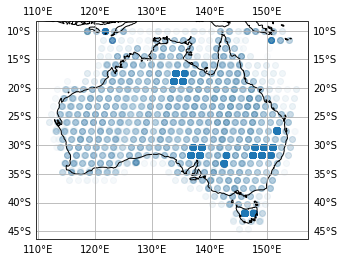

In [5]:
records = dc.find_datasets(product='ga_ls_fc_3')
#records = dc.find_datasets(product='ga_ls_wofs_3')
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.scatter(*zip(*[(i.extent.centroid.to_crs('epsg:4326').points)[0] for i in records]), alpha =0.02)
ax.coastlines()
g = ax.gridlines(draw_labels=True); g.top_labels = g.right_labels = True
None #feed a null to jupyter environment so it doesn't print an output above our graph

In [6]:
query = {'output_crs':'epsg:3577',
         'resolution':(-30,30),
         'group_by':'solar_day',
         'region_code':"090079",
         'lat':(-27.31, -27.41),
         'lon':(151.01, 151.12),
         'time':('2018-05-01', '2018-06-01')}

### Check out how much data we have

In [7]:
#count the number of datasets for fc3
datasets_fc3 = dc.find_datasets(product='ga_ls_fc_3', **query)
len(datasets_fc3)

4

### Load collection 3 fractional cover

In [8]:
ds_fc3 = dc.load(product='ga_ls_fc_3', 
                 **query, resampling = 'bilinear', #suggestion from kirill
                # dask_chunks={"time": 1, "x": 100, "y": 100},  
                 progress_cbk=with_ui_cbk())
#print(ds_fc3)

### Load collection 3 wofs to mask both collection 2 and 3 fractional cover (to keep comparison the same)

In [9]:
#count the number of datasets for wofs3
datasets_wofs3 = dc.find_datasets(product='ga_ls_wo_3', **query)
len(datasets_wofs3)

4

In [11]:
#load the wofs feature layers (wofls) within the same query as Fractional cover
wofls = dc.load(product='ga_ls_wo_3', 
                **query, 
                #dask_chunks={"time": 1, "x": 100, "y": 100},
                progress_cbk=with_ui_cbk())

### Turn the loaded wofls into a mask for fractional cover

In [14]:
wofsmask = masking.make_mask(wofls, wet=True)
#wofsmask.water.isel(time=0).plot()

### Load collection 2 fractional cover for each satellite separately

for collection 2 query, remove the 'region' setting from the dictionary as it doesn't exist in collection 3. This is useful to find the datasets for collection 2.

In [15]:
query_c2 = deepcopy(query) #copy original query to second dictionary
query_c2.pop('region_code', None) #remove region code from c2 query
None #don't print results
#query_c2

In [16]:
#count the number of datasets for fc2 ls5
datasets_ls5_fc2 = dc.find_datasets(product='ls5_fc_albers', **query_c2)
#count the number of datasets for fc2 ls7
datasets_ls7_fc2 = dc.find_datasets(product='ls7_fc_albers', **query_c2)
#count the number of datasets for fc2 ls8
datasets_ls8_fc2 = dc.find_datasets(product='ls8_fc_albers', **query_c2)

Load and concatenate fractional cover for collection 2 data

In [19]:
if datasets_ls5_fc2:
    print(f'loading {len(datasets_ls5_fc2)} ls5 fc c2')
    ds_fc2_5 = dc.load(product = 'ls5_fc_albers', 
                       like = ds_fc3, 
                       #dask_chunks={"time": 1, "x": 100, "y": 100},
                       progress_cbk=with_ui_cbk())
else:
    print('no ls5 fc c2')
    ds_fc2_5= None
    
if datasets_ls7_fc2:    
    print(f'loading {len(datasets_ls7_fc2)} ls7 fc c2')
    ds_fc2_7 = dc.load(product = 'ls7_fc_albers', 
                       like = ds_fc3, 
                       #dask_chunks={"time": 1, "x": 100, "y": 100},
                       progress_cbk=with_ui_cbk())
else:
    print('no ls7 fc c2')
    ds_fc2_7= None
    
if datasets_ls8_fc2:  
    print(f'loading {len(datasets_ls8_fc2)} ls8 fc c2')
    ds_fc2_8 = dc.load(product = 'ls8_fc_albers', 
                       like = ds_fc3, 
                       #dask_chunks={"time": 1, "x": 100, "y": 100},
                       progress_cbk=with_ui_cbk())
else:
    print('no ls8 fc c2')
    ds_fc2_8= None
    
#combine satellite data for the three landsats into one fractional cover dataset
ds_list = []
for i in [ds_fc2_5, ds_fc2_7, ds_fc2_8]:
    if i:
        ds_list.append(i)

no ls5 fc c2
loading 4 ls7 fc c2


loading 8 ls8 fc c2


In [23]:
#merge fractional cover for ls 5, 7, 8 into one dataset
ds_fc2 = xr.merge(ds_list)
#ds_fc2.time

## 

### Load collection 3 cloud mask to mask both collections 2 and 3 fractional cover

In [25]:
c3_ard = dea_datahandling.load_ard(dc, products = ['ga_ls5t_ard_3', 'ga_ls7e_ard_3','ga_ls8c_ard_3'],
                                   measurements =['nbart_red','nbart_green','nbart_blue','nbart_nir','nbart_swir_1', 'oa_fmask'], **query, 
                                  #dask_chunks={"time": 1, "x": 3000, "y": 3000}, #if you pick too small an area, this won't work
                                  dtype='native',
                                  progress_cbk=with_ui_cbk())

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Loading 4 time steps


### Match timesteps for all data

In [26]:
# # Remove milliseconds to make data comparable
ds_fc2['time'] = ds_fc2.indexes['time'].normalize()
ds_fc3['time'] = ds_fc3.indexes['time'].normalize()
wofsmask['time'] = wofsmask.indexes['time'].normalize()
c3_ard['time'] = c3_ard.indexes['time'].normalize()

In [27]:
# Choose matching timesteps to compare
ds_compare = ds_fc3["time"].isin(ds_fc2["time"].values)
ds_fc3_sel = ds_fc3.sel(time=ds_compare)
ds_fc2_sel = ds_fc2.where(ds_fc2.time == ds_fc3.time)

In [28]:
#free up memory 
del ds_fc2_5, ds_fc2_7, ds_fc2_8
del ds_fc2, ds_fc3, ds_compare, wofls 

### Rename collection 2 variables to make comparisons easier

In [29]:
#rename collection 2 variables so we can iterate through both datasets along the same set of variables
ds_fc2_sel= ds_fc2_sel.rename_vars({'BS':'bs','PV':'pv', 'NPV':'npv', 'UE':'ue'})

### work out what the nodata values are

In [30]:
print( ds_fc2_sel.bs.nodata,ds_fc3_sel.bs.nodata, c3_ard.nbart_red.nodata, c3_ard.oa_fmask.nodata)

-1 255 -999 0


### Mask everything with everything else

In [31]:
#replace nodata with NaNs so they plot nicely
ds_fc2_sel = ds_fc2_sel.where(ds_fc2_sel!=-1)
ds_fc3_sel = ds_fc3_sel.where(ds_fc3_sel!=255)

#to compare both datasets, take data only where both sets have finite data
ds_fc2_sel = ds_fc2_sel.where(ds_fc3_sel.notnull()==True)
ds_fc3_sel = ds_fc3_sel.where(ds_fc2_sel.notnull()==True)

#turn collection 3 into a boolean mask to remove nodata in the fractional cover collections
c3_bool = (c3_ard.nbart_red!=c3_ard.nbart_red.nodata)

#to compare both datasets, take data only where both sets have finite data
ds_fc2_sel = ds_fc2_sel.where(ds_fc3_sel.notnull())
ds_fc3_sel = ds_fc3_sel.where(ds_fc2_sel.notnull())


#mask out water from the fractional cover data
ds_fc3_sel = ds_fc3_sel.where(wofsmask.water==False)
ds_fc2_sel = ds_fc2_sel.where(wofsmask.water==False)


# #mask out clouds from the fractional cover data
if c3_ard:   
    ds_fc2_masked = ds_fc2_sel.where(c3_bool==True)
    ds_fc3_masked = ds_fc3_sel.where(c3_bool==True)
else:
    print('no cloud mask  found')

### Plot Fractional Cover and Unmixing Error Bands

In [32]:
#just a scene we want to plot - this can be done other ways
scene = 1
#get the date of the scene for our output
scene_day= np.datetime_as_string(ds_fc3_sel.isel(time=scene).time.values, unit='D')

Set up a colormap for the comparison

In [33]:
#div_cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
div_pal = sns.diverging_palette(250, 30, l=65, n=21 , center="dark")
#(start=2.8, rot=.1, light=0.9, n_colors=3)
div_cmap=ListedColormap(div_pal)
ticks=np.linspace(-10,10,1)

In [41]:
#choose values for the comparison visualisation bounds
compmin =-10
compmax =10

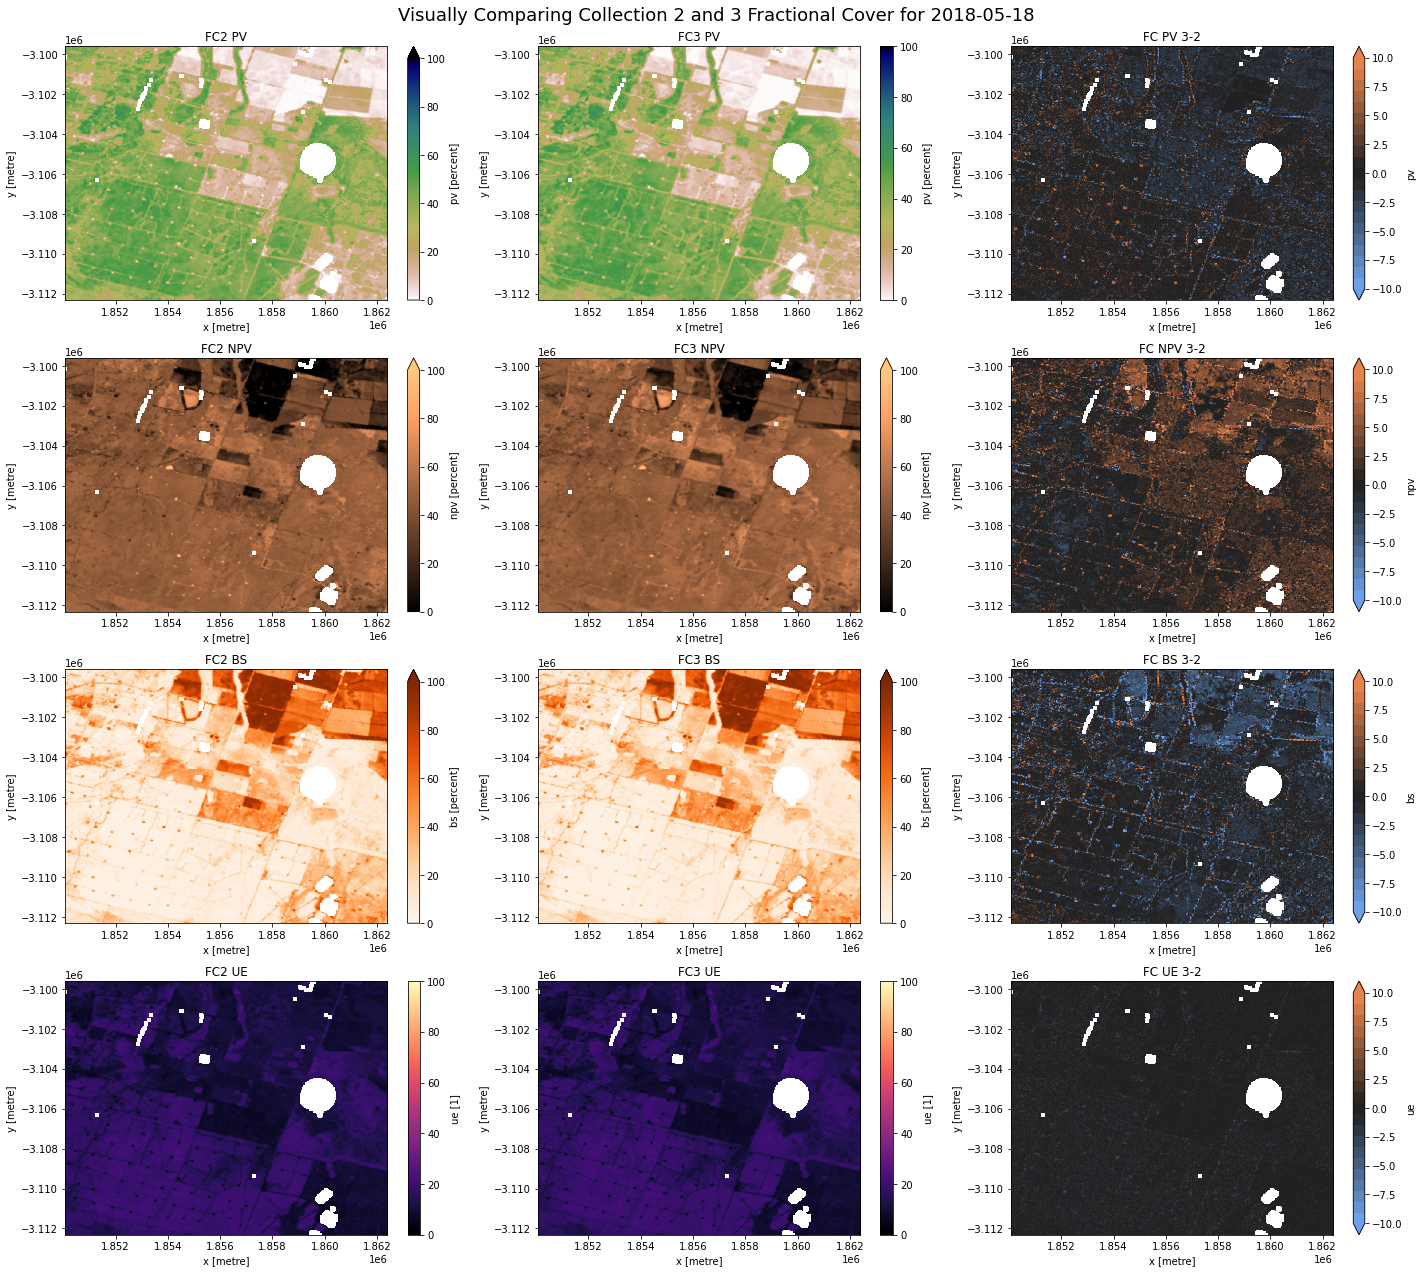

In [42]:
#set up our images on a grid using gridspec
fig = plt.figure(figsize=(20,18))
gs = gridspec.GridSpec(4,3) 

#plot Collection 2 Photosynthetic Veg
ax1=plt.subplot(gs[0,0])
ds_fc2_masked.pv.isel(time=scene).plot.imshow(interpolation='gaussian',cmap='gist_earth_r', vmin=0, vmax=100)
ax1.set_title('FC2 PV')

#Plot Collection 3 Photosynthetic Veg
ax1=plt.subplot(gs[0,1])
ds_fc3_masked.pv.isel(time=scene).plot.imshow(interpolation='gaussian',cmap='gist_earth_r',vmin=0, vmax=100)
ax1.set_title('FC3 PV')

#Plot the delta
ax1=plt.subplot(gs[0,2])
(ds_fc3_masked.pv.isel(time=scene) - ds_fc2_masked.pv.isel(time=scene)).plot.imshow(interpolation='gaussian',cmap=div_cmap, vmin=compmin, vmax=compmax)

ax1.set_title('FC PV 3-2')

#plot Collection 2  Non-Photosynthetic Veg
ax3=plt.subplot(gs[1,0])
ds_fc2_masked.npv.isel(time=scene).plot.imshow(interpolation='gaussian',cmap='copper',vmin=0, vmax=100)
ax3.set_title('FC2 NPV')

#plot Collection 3  Non-Photosynthetic Veg
ax3=plt.subplot(gs[1,1])
ds_fc3_masked.npv.isel(time=scene).plot.imshow(interpolation='gaussian',cmap='copper',vmin=0, vmax=100)
ax3.set_title('FC3 NPV')

#Plot the delta  
ax3=plt.subplot(gs[1,2])
(ds_fc3_masked.npv.isel(time=scene) - ds_fc2_masked.npv.isel(time=scene)).plot.imshow(interpolation='gaussian',cmap=div_cmap,vmin=compmin, vmax=compmax)
ax3.set_title('FC NPV 3-2')

#plot Collection 2  Bare Soil
ax3=plt.subplot(gs[2,0])
ds_fc2_masked.bs.isel(time=scene).plot.imshow(interpolation='gaussian',cmap='Oranges',vmin=0, vmax=100)
ax3.set_title('FC2 BS')

#plot Collection 3  Bare Soil
ax3=plt.subplot(gs[2,1])
ds_fc2_masked.bs.isel(time=scene).plot.imshow(interpolation='gaussian',cmap='Oranges',vmin=0, vmax=100)
ax3.set_title('FC3 BS')

#Plot the delta  
ax3=plt.subplot(gs[2,2])
(ds_fc3_masked.bs.isel(time=scene) - ds_fc2_masked.bs.isel(time=scene)).plot.imshow(interpolation='gaussian',cmap=div_cmap, vmin=compmin, vmax=compmax)
ax3.set_title('FC BS 3-2')

#plot Collection 2  Unmixing Error
ax3=plt.subplot(gs[3,0])
ds_fc2_masked.ue.isel(time=scene).plot.imshow(interpolation='gaussian',cmap='magma',vmin=0, vmax=100)
ax3.set_title('FC2 UE')

#plot Collection 3  Unmixing Error
ax3=plt.subplot(gs[3,1])
ds_fc2_masked.ue.isel(time=scene).plot.imshow(interpolation='gaussian',cmap='magma',vmin=0, vmax=100)
ax3.set_title('FC3 UE')

#Plot the delta  
ax3=plt.subplot(gs[3,2])
(ds_fc3_masked.ue.isel(time=scene) - ds_fc2_masked.ue.isel(time=scene)).plot.imshow(interpolation='gaussian',cmap=div_cmap, vmin=compmin, vmax=compmax)
ax3.set_title('FC UE 3-2')

fig.suptitle(f'Visually Comparing Collection 2 and 3 Fractional Cover for {scene_day}', size=18)
gs.tight_layout(fig, rect=[0, 0, 1, 0.97])

plt.savefig(fname = f'../outputs/FC_comparison_511_{scene_day}.png')
plt.show()
None

In [44]:
ds_fc2_masked

<xarray.Dataset>
Dimensions:      (time: 3, x: 411, y: 424)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-10 2018-05-18 2018-05-26
  * y            (y) float64 -3.1e+06 -3.1e+06 ... -3.112e+06 -3.112e+06
  * x            (x) float64 1.85e+06 1.85e+06 1.85e+06 ... 1.862e+06 1.862e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) float64 nan nan nan nan ... 46.0 28.0 37.0 31.0
    pv           (time, y, x) float64 nan nan nan nan ... 16.0 11.0 15.0 17.0
    npv          (time, y, x) float64 nan nan nan nan ... 36.0 60.0 47.0 51.0
    ue           (time, y, x) float64 nan nan nan nan nan ... 8.0 7.0 8.0 9.0

In [66]:
def scatter_fc(fc2_dataset, fc3_dataset, fraction: str="pv", timestep: int=0, s=1, **kwargs):
    '''Scatter plot collection 2 fractional cover data against collection 3
       fraction is one of pv, npv or bs '''
    plt.figure(figsize=(10,10))
    fc2 = fc2_dataset[fraction].isel(time=timestep)
    fc3 = fc3_dataset[fraction].isel(time=timestep)
    plt.scatter(fc2.values.ravel(), fc3.values.ravel(), s=s, edgecolor="None", **kwargs)

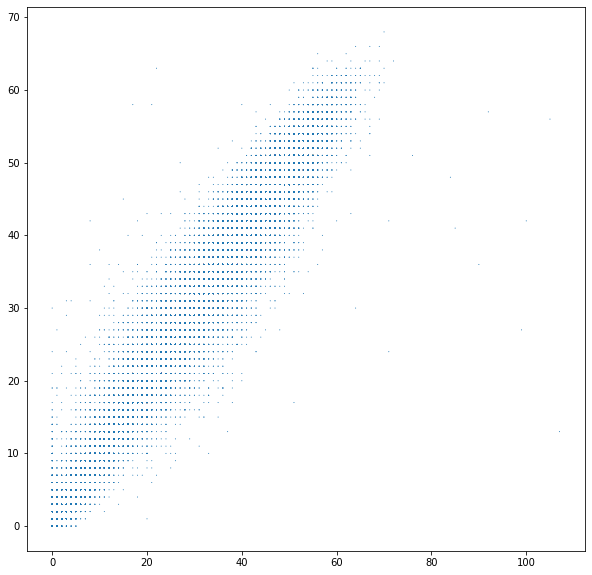

In [67]:
scatter_fc(ds_fc2_masked, ds_fc3_masked)